In [1]:
import sys
sys.path.append('../../Share/')
sys.path.append('../../V5 Self Supervised Learning')

import self_supervised_v1
import matplotlib.pyplot as plt
import baseline, config

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

trainer_Minjeong = baseline.ModelTrainer(config, subject="Minjeong")
trainer_Carlson = baseline.ModelTrainer(config, subject="Carlson")
trainer_Harold = baseline.ModelTrainer(config, subject="Harold")
trainer_Hunmin = baseline.ModelTrainer(config, subject="Hunmin")
trainer_Brian = baseline.ModelTrainer(config, subject="Brian")
trainer_Xianyu = baseline.ModelTrainer(config, subject="Xianyu")

In [2]:
def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]

import pandas as pd

import numpy as np
from sklearn.utils import resample

def down_sample(X, y):
    X = np.array(X)
    y = np.array(y)

    # 클래스별 최소 개수
    unique_classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    X_balanced, y_balanced = [], []

    for cls in unique_classes:
        idx = np.where(y == cls)[0]  # 해당 클래스 인덱스
        down_idx = resample(idx, replace=False, n_samples=min_count, random_state=42)
        X_balanced.append(X[down_idx])
        y_balanced.append(y[down_idx])

    # 합치기
    X_balanced = np.concatenate(X_balanced, axis=0)
    y_balanced = np.concatenate(y_balanced, axis=0)

    return X_balanced, y_balanced


In [ ]:
SUBJECT = "Harold"
Threshold_K = 10
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

model = self_supervised_v1.build_model()
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
model.save('./model_K10_H2.h5')

Start : H
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/66 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/66 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/
Dataset 13/66 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/
Dataset 14/66 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/
Dataset 15/66 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 16/66 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/
Dataset 17/66 - Session Exp_2025-06-24-v3/E9AD0E7DCC2B/
Dataset 18/66 - Session Exp_2025-06-24-v4/E9AD0E7DCC2

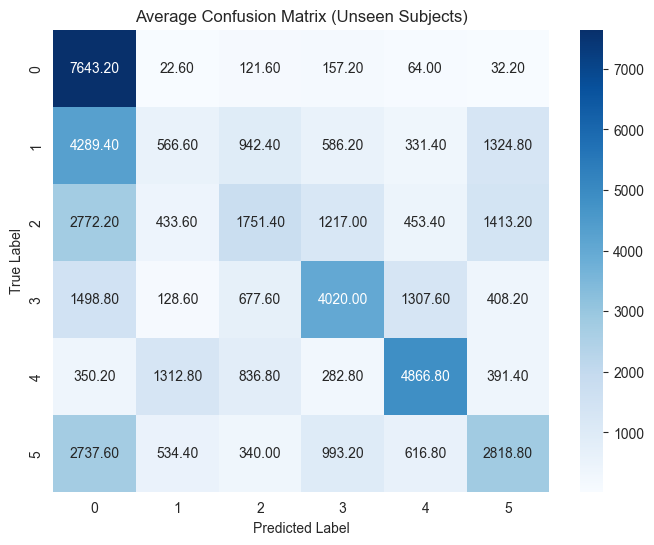

In [4]:
model = load_model('./model_K10_H2.h5')
model.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "C": [], "B": [], "X": [], "M": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "B": trainer_Brian,
    "X": trainer_Xianyu,
    "M": trainer_Minjeong
}

n_classes = 6
cm_total = np.zeros((n_classes, n_classes))  # 누적 confusion matrix

# Unseen subject 테스트
for key, trainer_sub in trainers_unseen.items():
    print(f"Start : {key}")
    if key == "H": final_session = len(config.Info_sub_H)
    elif key == "C": final_session = len(config.Info_sub_C)
    elif key == "B": final_session = len(config.Info_sub_B)
    elif key == "X": final_session = len(config.Info_sub_X)
    elif key == "M": final_session = len(config.Info_sub_M)

    unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=final_session, train_ratio=0.8)
    X_test, y_test = down_sample(unseen_X, unseen_y)
    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))
    cm_total += cm

    acc = np.mean(y_pred == y_test)
    Unseen_subject_acc_dict[key].append(acc)

# 평균 confusion matrix 계산
cm_avg = cm_total / len(trainers_unseen)
cm_norm = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]

pd.DataFrame(cm_avg).to_csv("./confusion_matrix_avg_H2.csv")
pd.DataFrame(cm_norm).to_csv("./confusion_matrix_avg_norm_H2.csv")

plt.figure(figsize=(8,6))
sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Confusion Matrix (Unseen Subjects)")
plt.show()

In [15]:
Unseen_subject_acc_dict

{'H': [0.5117903351783752],
 'C': [0.31158745288848877],
 'B': [0.48494505882263184],
 'X': [0.2847261428833008],
 'M': [0.38783326745033264]}

In [19]:
SUBJECT = "Brian"
Threshold_K = 10
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

model = self_supervised_v1.build_model()
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
model.save('./model_K10_B.h5')

Dataset 1/14 - Session Exp_2025-06-27-v1/E9AD0E7DCC2B/
Dataset 2/14 - Session Exp_2025-06-27-v2/E9AD0E7DCC2B/
Dataset 3/14 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/14 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/14 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/14 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 7/14 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 8/14 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/
Dataset 9/14 - Session Exp_2025-07-17-v1/E9AD0E7DCC2B/
Dataset 10/14 - Session Exp_2025-07-17-v2/E9AD0E7DCC2B/
(68912, 4, 14, 1) (68912,) (17227, 4, 14, 1) (17227,)


Start : H
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/66 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/66 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/
Dataset 13/66 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/
Dataset 14/66 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/
Dataset 15/66 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 16/66 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/
Dataset 17/66 - Session Exp_2025-06-24-v3/E9AD0E7DCC2B/
Dataset 18/66 - Session Exp_2025-06-24-v4/E9AD0E7DCC2

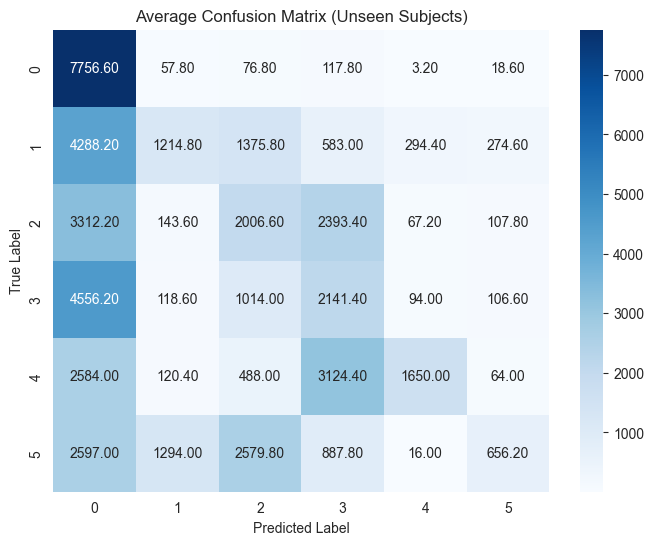

In [6]:
model = load_model('./model_K10_B.h5')
model.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "C": [], "H2": [], "X": [], "M": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    "X": trainer_Xianyu,
    "M": trainer_Minjeong
}

n_classes = 6
cm_total = np.zeros((n_classes, n_classes))  # 누적 confusion matrix

# Unseen subject 테스트
for key, trainer_sub in trainers_unseen.items():
    print(f"Start : {key}")
    if key == "H": final_session = len(config.Info_sub_H)
    elif key == "C": final_session = len(config.Info_sub_C)
    elif key == "H2": final_session = len(config.Info_sub_H2)
    elif key == "X": final_session = len(config.Info_sub_X)
    elif key == "M": final_session = len(config.Info_sub_M)

    unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=final_session, train_ratio=0.8)
    X_test, y_test = down_sample(unseen_X, unseen_y)
    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))
    cm_total += cm

    acc = np.mean(y_pred == y_test)
    Unseen_subject_acc_dict[key].append(acc)

# 평균 confusion matrix 계산
cm_avg = cm_total / len(trainers_unseen)
cm_norm = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]

pd.DataFrame(cm_avg).to_csv("./confusion_matrix_avg_B.csv")
pd.DataFrame(cm_norm).to_csv("./confusion_matrix_avg_norm_B.csv")

plt.figure(figsize=(8,6))
sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Confusion Matrix (Unseen Subjects)")
plt.show()

In [21]:
Unseen_subject_acc_dict

{'H': [0.32528555393218994],
 'C': [0.2836424708366394],
 'H2': [0.37295523285865784],
 'X': [0.2859489619731903],
 'M': [0.31237921118736267]}

In [22]:
SUBJECT = "Carlson"
Threshold_K = 10
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

model = self_supervised_v1.build_model()
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
model.save('./model_K10_C.h5')

Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 7/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 8/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/
Dataset 9/18 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 10/18 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/
(68667, 4, 14, 1) (68667,) (17166, 4, 14, 1) (17166,)


Start : H
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/66 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/66 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/
Dataset 13/66 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/
Dataset 14/66 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/
Dataset 15/66 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 16/66 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/
Dataset 17/66 - Session Exp_2025-06-24-v3/E9AD0E7DCC2B/
Dataset 18/66 - Session Exp_2025-06-24-v4/E9AD0E7DCC2

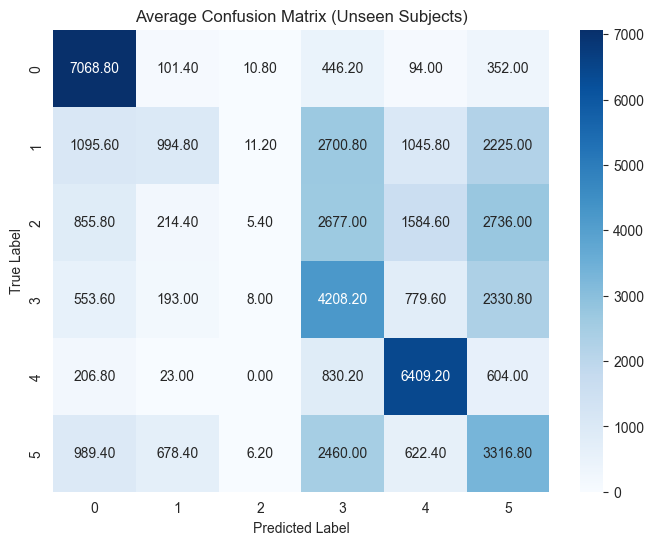

In [7]:
model = load_model('./model_K10_C.h5')
model.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "B": [], "H2": [], "X": [], "M": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "B": trainer_Brian,
    "H2": trainer_Harold,
    "X": trainer_Xianyu,
    "M": trainer_Minjeong
}

n_classes = 6
cm_total = np.zeros((n_classes, n_classes))  # 누적 confusion matrix

# Unseen subject 테스트
for key, trainer_sub in trainers_unseen.items():
    print(f"Start : {key}")
    if key == "H": final_session = len(config.Info_sub_H)
    elif key == "B": final_session = len(config.Info_sub_B)
    elif key == "H2": final_session = len(config.Info_sub_H2)
    elif key == "X": final_session = len(config.Info_sub_X)
    elif key == "M": final_session = len(config.Info_sub_M)

    unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=final_session, train_ratio=0.8)
    X_test, y_test = down_sample(unseen_X, unseen_y)
    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))
    cm_total += cm

    acc = np.mean(y_pred == y_test)
    Unseen_subject_acc_dict[key].append(acc)

# 평균 confusion matrix 계산
cm_avg = cm_total / len(trainers_unseen)
cm_norm = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]

pd.DataFrame(cm_avg).to_csv("./confusion_matrix_avg_C.csv")
pd.DataFrame(cm_norm).to_csv("./confusion_matrix_avg_norm_C.csv")

plt.figure(figsize=(8,6))
sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Confusion Matrix (Unseen Subjects)")
plt.show()

In [24]:
Unseen_subject_acc_dict

{'H': [0.4770466089248657],
 'B': [0.41935721039772034],
 'H2': [0.5213943123817444],
 'X': [0.3226229250431061],
 'M': [0.470665842294693]}

In [25]:
SUBJECT = "Xianyu"
Threshold_K = 10
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

model = self_supervised_v1.build_model()
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
model.save('./model_K10_X.h5')

Dataset 1/18 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-06-26-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-06-26-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-06-27-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-06-27-v2/E9AD0E7DCC2B/
Dataset 7/18 - Session Exp_2025-06-30-v1/FEFFF6FFF5FF/
Dataset 8/18 - Session Exp_2025-06-30-v2/FEFFF6FFF5FF/
Dataset 9/18 - Session Exp_2025-07-01-v1/E9AD0E7DCC2B/
Dataset 10/18 - Session Exp_2025-07-01-v2/E9AD0E7DCC2B/
(68232, 4, 14, 1) (68232,) (17057, 4, 14, 1) (17057,)


Start : H
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/66 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/66 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/
Dataset 13/66 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/
Dataset 14/66 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/
Dataset 15/66 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 16/66 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/
Dataset 17/66 - Session Exp_2025-06-24-v3/E9AD0E7DCC2B/
Dataset 18/66 - Session Exp_2025-06-24-v4/E9AD0E7DCC2

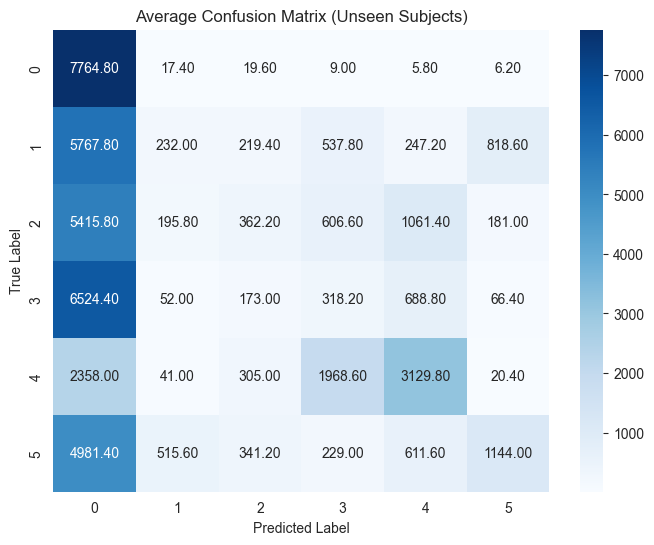

In [8]:
model = load_model('./model_K10_X.h5')
model.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "B": [], "H2": [], "C": [], "M": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "B": trainer_Brian,
    "H2": trainer_Harold,
    "C": trainer_Carlson,
    "M": trainer_Minjeong
}

n_classes = 6
cm_total = np.zeros((n_classes, n_classes))  # 누적 confusion matrix

# Unseen subject 테스트
for key, trainer_sub in trainers_unseen.items():
    print(f"Start : {key}")
    if key == "H": final_session = len(config.Info_sub_H)
    elif key == "B": final_session = len(config.Info_sub_B)
    elif key == "H2": final_session = len(config.Info_sub_H2)
    elif key == "C": final_session = len(config.Info_sub_C)
    elif key == "M": final_session = len(config.Info_sub_M)

    unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=final_session, train_ratio=0.8)
    X_test, y_test = down_sample(unseen_X, unseen_y)
    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))
    cm_total += cm

    acc = np.mean(y_pred == y_test)
    Unseen_subject_acc_dict[key].append(acc)

# 평균 confusion matrix 계산
cm_avg = cm_total / len(trainers_unseen)
cm_norm = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]

pd.DataFrame(cm_avg).to_csv("./confusion_matrix_avg_X.csv")
pd.DataFrame(cm_norm).to_csv("./confusion_matrix_avg_norm_X.csv")

plt.figure(figsize=(8,6))
sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Confusion Matrix (Unseen Subjects)")
plt.show()

In [28]:
Unseen_subject_acc_dict

{'H': [0.2629649043083191],
 'C': [0.21327358484268188],
 'B': [0.3598134219646454],
 'H2': [0.34199339151382446],
 'M': [0.24675127863883972]}

In [34]:
SUBJECT = "Minjeong"
Threshold_K = 10
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

model = self_supervised_v1.build_model()
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
model.save('./model_K10_M.h5')

Dataset 1/18 - Session Exp_2025-08-01-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-08-01-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-08-02-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-08-02-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-08-09-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-08-09-v2/E9AD0E7DCC2B/
Dataset 7/18 - Session Exp_2025-08-10-v1/E9AD0E7DCC2B/
Dataset 8/18 - Session Exp_2025-08-10-v2/E9AD0E7DCC2B/
Dataset 9/18 - Session Exp_2025-08-11-v1/E9AD0E7DCC2B/
Dataset 10/18 - Session Exp_2025-08-11-v2/E9AD0E7DCC2B/
(69076, 4, 14, 1) (69076,) (17269, 4, 14, 1) (17269,)


Start : H
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/66 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/66 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/
Dataset 13/66 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/
Dataset 14/66 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/
Dataset 15/66 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 16/66 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/
Dataset 17/66 - Session Exp_2025-06-24-v3/E9AD0E7DCC2B/
Dataset 18/66 - Session Exp_2025-06-24-v4/E9AD0E7DCC2

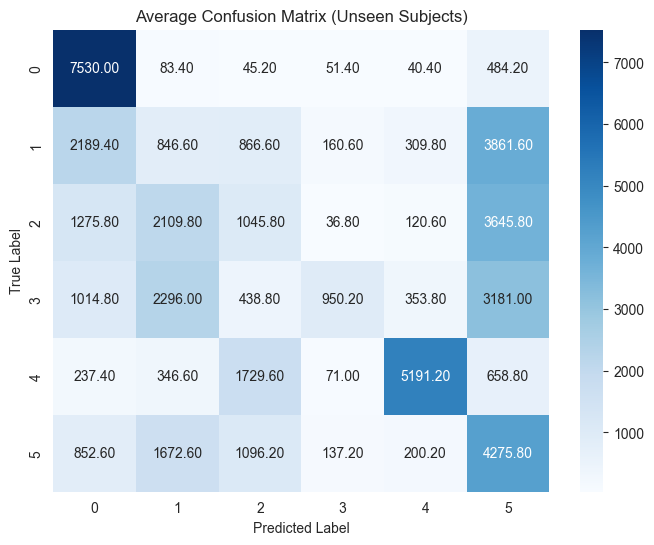

In [9]:
model = load_model('./model_K10_M.h5')
model.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "B": [], "H2": [], "C": [], "X": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "B": trainer_Brian,
    "H2": trainer_Harold,
    "C": trainer_Carlson,
    "X": trainer_Xianyu
}

n_classes = 6
cm_total = np.zeros((n_classes, n_classes))  # 누적 confusion matrix

# Unseen subject 테스트
for key, trainer_sub in trainers_unseen.items():
    print(f"Start : {key}")
    if key == "H": final_session = len(config.Info_sub_H)
    elif key == "B": final_session = len(config.Info_sub_B)
    elif key == "H2": final_session = len(config.Info_sub_H2)
    elif key == "C": final_session = len(config.Info_sub_C)
    elif key == "X": final_session = len(config.Info_sub_X)

    unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=final_session, train_ratio=0.8)
    X_test, y_test = down_sample(unseen_X, unseen_y)
    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))
    cm_total += cm

    acc = np.mean(y_pred == y_test)
    Unseen_subject_acc_dict[key].append(acc)

# 평균 confusion matrix 계산
cm_avg = cm_total / len(trainers_unseen)
cm_norm = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]

pd.DataFrame(cm_avg).to_csv("./confusion_matrix_avg_M.csv")
pd.DataFrame(cm_norm).to_csv("./confusion_matrix_avg_norm_M.csv")

plt.figure(figsize=(8,6))
sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Confusion Matrix (Unseen Subjects)")
plt.show()

In [36]:
Unseen_subject_acc_dict

{'H': [0.43903976678848267],
 'C': [0.31474313139915466],
 'B': [0.4432436525821686],
 'H2': [0.3920263350009918],
 'X': [0.2793212831020355]}

In [31]:
from tensorflow.keras.models import load_model

model = load_model('C:/Users/hml76/PycharmProjects/MindForce/github/V5 Self Supervised Learning/V1 - Semi Supervised Learning in online(Pseudo-labeling)/model_K10_H.h5')

In [ ]:
model = load_model('./model_K10_H.h5')
model.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"M": [], "B": [], "H2": [], "C": [], "X": []}
trainers_unseen = {
    "M": trainer_Minjeong,
    "B": trainer_Brian,
    "H2": trainer_Harold,
    "C": trainer_Carlson,
    "X": trainer_Xianyu
}

n_classes = 6
cm_total = np.zeros((n_classes, n_classes))  # 누적 confusion matrix

# Unseen subject 테스트
for key, trainer_sub in trainers_unseen.items():
    print(f"Start : {key}")
    if key == "M": final_session = len(config.Info_sub_M)
    elif key == "B": final_session = len(config.Info_sub_B)
    elif key == "H2": final_session = len(config.Info_sub_H2)
    elif key == "C": final_session = len(config.Info_sub_C)
    elif key == "X": final_session = len(config.Info_sub_X)

    unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=final_session, train_ratio=0.8)
    X_test, y_test = down_sample(unseen_X, unseen_y)
    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))
    cm_total += cm

    acc = np.mean(y_pred == y_test)
    Unseen_subject_acc_dict[key].append(acc)

# 평균 confusion matrix 계산
cm_avg = cm_total / len(trainers_unseen)
cm_norm = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]

pd.DataFrame(cm_avg).to_csv("./confusion_matrix_avg_H.csv")
pd.DataFrame(cm_norm).to_csv("./confusion_matrix_avg_norm_H.csv")

plt.figure(figsize=(8,6))
sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Confusion Matrix (Unseen Subjects)")
plt.show()

Start : M
Dataset 1/18 - Session Exp_2025-08-01-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-08-01-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-08-02-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-08-02-v2/E9AD0E7DCC2B/


In [33]:
Unseen_subject_acc_dict

{'B': [0.48227420449256897],
 'C': [0.3064776360988617],
 'H2': [0.6157763600349426],
 'X': [0.3257503807544708],
 'M': [0.37346524000167847]}